###  This File is used for Ideation and Testing. Use postprocess notebook for the finalized version

In [46]:
CONF_3 = "../yjpa_scraper/items_listing/sam/mask/output_labels/conf_3"
CONF_2 = "../yjpa_scraper/items_listing/sam/mask/output_labels/conf_2"
CONF_1 = "../yjpa_scraper/items_listing/sam/mask/output_labels/conf_1"
RAW = "../yjpa_scraper/items_listing/raw"
ITEM = 108
AUCTION = "l1190792038"
IOU_THRESH = 0.9
# TEXT_PROMPT_CSV = "../yjpa_scraper/items-prompt.csv"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..77.2].


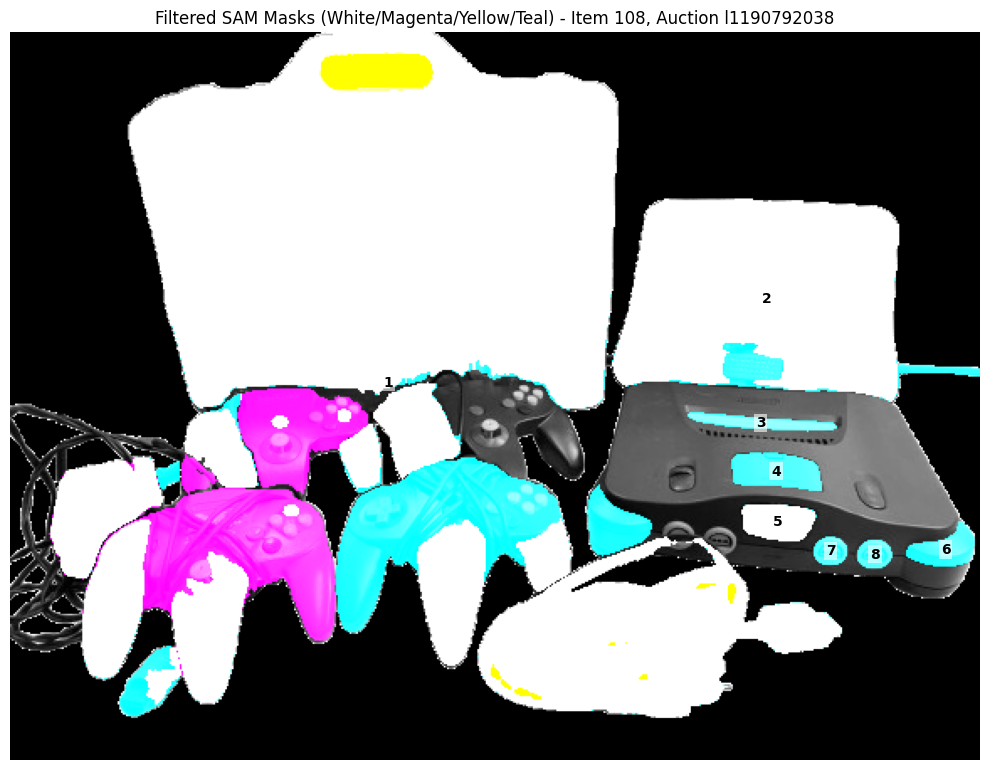

In [62]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops


# Build file paths
raw_image_path = os.path.join(RAW, str(ITEM), f"{AUCTION}.png")
conf_paths = {
    "conf_1": os.path.join(CONF_1, str(ITEM), f"{AUCTION}.npy"),
    "conf_2": os.path.join(CONF_2, str(ITEM), f"{AUCTION}.npy"),
    "conf_3": os.path.join(CONF_3, str(ITEM), f"{AUCTION}.npy"),
}

# Load raw image with alpha
raw_image = cv2.imread(raw_image_path, cv2.IMREAD_UNCHANGED)
if raw_image is None:
    raise FileNotFoundError(f"Could not load image at: {raw_image_path}")
if raw_image.shape[2] != 4:
    raise ValueError("Expected image with alpha channel.")

# Convert to grayscale RGB
bgr = raw_image[:, :, :3]
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
gray_rgb = np.stack([gray] * 3, axis=-1).astype(np.float32) / 255.0
alpha = raw_image[:, :, 3]
transparent_mask = alpha == 0
overlay = gray_rgb.copy()

# Colors per confidence
conf_colors = {
    "conf_1": (255, 0.0, 0.0),  # Red
    "conf_2": (0.0, 255, 0.0),  # Green
    "conf_3": (0.0, 0.0, 255),  # Blue
}

# Initialize confidence layers
mask_layers = {
    "conf_1": np.zeros(alpha.shape, dtype=bool),
    "conf_2": np.zeros(alpha.shape, dtype=bool),
    "conf_3": np.zeros(alpha.shape, dtype=bool),
}

# Load and assign masks into layers (after alpha filtering)
for conf_key, conf_path in conf_paths.items():
    if not os.path.exists(conf_path):
        print(f"Warning: Missing mask file: {conf_path}")
        continue

    masks_array = np.load(conf_path, allow_pickle=True)

    for m in masks_array:
        mask = m['segmentation'] if isinstance(m, dict) else m
        if mask.shape != alpha.shape:
            mask = cv2.resize(mask.astype(np.uint8), (alpha.shape[1], alpha.shape[0]), interpolation=cv2.INTER_NEAREST).astype(bool)

        overlap = np.logical_and(mask, transparent_mask)
        overlap_ratio = overlap.sum() / mask.sum()

        if overlap_ratio <= 0.9:
            mask_layers[conf_key] = np.logical_or(mask_layers[conf_key], mask)

# Compute mask combinations
c1 = mask_layers["conf_1"]
c2 = mask_layers["conf_2"]
c3 = mask_layers["conf_3"]

# Each pixel gets a 3-bit code based on mask presence
combo_code = (c1.astype(np.uint8) << 2) + (c2.astype(np.uint8) << 1) + c3.astype(np.uint8)
unique_vals, counts = np.unique(combo_code, return_counts=True)


# Overlay only valid colors
color_map = {
    3: (255, 255, 0.0),    # Yellow (conf_1 + conf_2)
    5: (255, 0.0, 255),    # Magenta (conf_1 + conf_3)
    6: (0.0, 255, 255),    # Light Blue (conf_2 + conf_3)
    7: (255, 255, 255),    # White (conf_1 + conf_2 + conf_3)
}

# Keep only codes for White (7), Teal (6), Magenta (5), Yellow (3)
combined_mask = np.isin(combo_code, list(color_map.keys()))
labeled_mask = label(combined_mask)
overlay = gray_rgb.copy()

for code, color in color_map.items():
    region = combo_code == code
    region_3c = np.repeat(region[:, :, np.newaxis], 3, axis=2)
    overlay = np.where(region_3c, overlay * 0.7 + np.array(color).reshape(1, 1, 3) * 0.3, overlay)

# --- Plot with region labels
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.title(f"Filtered SAM Masks (White/Magenta/Yellow/Teal) - Item {ITEM}, Auction {AUCTION}")

# Label each connected component
for region in regionprops(labeled_mask):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='black', fontsize=10, weight='bold',
             ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', pad=1.5, alpha=0.6))

plt.axis("off")
plt.tight_layout()
plt.show()



## IOU Method

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Build file paths
raw_image_path = os.path.join(RAW, str(ITEM), f"{AUCTION}.png")
conf_paths = {
    "conf_1": os.path.join(CONF_1, str(ITEM), f"{AUCTION}.npy"),
    "conf_2": os.path.join(CONF_2, str(ITEM), f"{AUCTION}.npy"),
    "conf_3": os.path.join(CONF_3, str(ITEM), f"{AUCTION}.npy"),
}

# Load raw image with alpha
raw_image = cv2.imread(raw_image_path, cv2.IMREAD_UNCHANGED)
if raw_image is None:
    raise FileNotFoundError(f"Could not load image at: {raw_image_path}")
if raw_image.shape[2] != 4:
    raise ValueError("Expected image with alpha channel.")

# Convert to grayscale RGB
bgr = raw_image[:, :, :3]
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
gray_rgb = np.stack([gray] * 3, axis=-1).astype(np.float32) / 255.0
alpha = raw_image[:, :, 3]
transparent_mask = alpha == 0

# Initialize mask layers
mask_layers = {
    "conf_1": np.zeros(alpha.shape, dtype=bool),
    "conf_2": np.zeros(alpha.shape, dtype=bool),
    "conf_3": np.zeros(alpha.shape, dtype=bool),
}

# Load and filter masks by alpha overlap
for conf_key, conf_path in conf_paths.items():
    if not os.path.exists(conf_path):
        print(f"Warning: Missing mask file: {conf_path}")
        continue
    masks_array = np.load(conf_path, allow_pickle=True)
    for m in masks_array:
        mask = m['segmentation'] if isinstance(m, dict) else m
        if mask.shape != alpha.shape:
            mask = cv2.resize(mask.astype(np.uint8), (alpha.shape[1], alpha.shape[0]), interpolation=cv2.INTER_NEAREST).astype(bool)
        overlap = np.logical_and(mask, transparent_mask)
        overlap_ratio = overlap.sum() / mask.sum()
        if overlap_ratio <= 0.9:
            mask_layers[conf_key] = np.logical_or(mask_layers[conf_key], mask)

# Compute 3-bit combo code
c1 = mask_layers["conf_1"]
c2 = mask_layers["conf_2"]
c3 = mask_layers["conf_3"]
combo_code = (c1.astype(np.uint8) << 2) + (c2.astype(np.uint8) << 1) + c3.astype(np.uint8)
color_mask  = np.isin(combo_code, [3, 5, 6, 7])   # yellow, magenta, teal
white_mask  = combo_code == 7


# Label each group
labeled_white = label(white_mask)
labeled_color = label(color_mask)

# Merge logic: keep white masks, and merge overlapping colored ones (90% containment of white within colored)
final_mask = np.zeros_like(white_mask, dtype=np.uint16)
instance_id = 1

for white_region in regionprops(labeled_white):
    white_obj = labeled_white == white_region.label
    merged_obj = white_obj.copy()
    for color_region in regionprops(labeled_color):
        color_obj = labeled_color == color_region.label

        # Compute how much of the white is covered by the color
        intersection = np.logical_and(white_obj, color_obj).sum()
        containment_ratio = intersection / white_obj.sum()
        
        # DEBUG
#         if intersection > 0:
#             print("color:{} white:{} intersection:{}".format(color_obj.sum(), white_obj.sum(), intersection))
#             print("containment ratio:", containment_ratio)
        
        # Union: expand white to include entire color region
        if containment_ratio >= IOU_THRESH:
            merged_obj = np.logical_or(color_obj,merged_obj)
            break
    
    final_mask[merged_obj] = instance_id
    instance_id += 1

    
# Visualization: color each final mask instance
num_instances = final_mask.max()
colors = plt.cm.get_cmap("tab20", num_instances + 1)

plt.figure(figsize=(6, 6))
plt.imshow(final_mask, cmap="nipy_spectral", vmin=0, vmax=num_instances)

# Label items
for region in regionprops(final_mask):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='white', fontsize=10, ha='center', va='center',
            bbox=dict(facecolor='black', edgecolor='none', pad=1, alpha=0.5))

plt.title("IOU Merging ({} labels)".format(num_instances))
plt.axis('off')
plt.tight_layout()
plt.show()


## Watershed Method

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.measure import label

# Build file paths
raw_image_path = os.path.join(RAW, str(ITEM), f"{AUCTION}.png")
conf_paths = {
    "conf_1": os.path.join(CONF_1, str(ITEM), f"{AUCTION}.npy"),
    "conf_2": os.path.join(CONF_2, str(ITEM), f"{AUCTION}.npy"),
    "conf_3": os.path.join(CONF_3, str(ITEM), f"{AUCTION}.npy"),
}

# Load raw image with alpha
raw_image = cv2.imread(raw_image_path, cv2.IMREAD_UNCHANGED)
if raw_image is None:
    raise FileNotFoundError(f"Could not load image at: {raw_image_path}")
if raw_image.shape[2] != 4:
    raise ValueError("Expected image with alpha channel.")

# Convert to grayscale RGB
bgr = raw_image[:, :, :3]
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
gray_rgb = np.stack([gray] * 3, axis=-1).astype(np.float32) / 255.0
alpha = raw_image[:, :, 3]
transparent_mask = alpha == 0

# Initialize mask layers
mask_layers = {
    "conf_1": np.zeros(alpha.shape, dtype=bool),
    "conf_2": np.zeros(alpha.shape, dtype=bool),
    "conf_3": np.zeros(alpha.shape, dtype=bool),
}

# Load and filter masks by alpha overlap
for conf_key, conf_path in conf_paths.items():
    if not os.path.exists(conf_path):
        print(f"Warning: Missing mask file: {conf_path}")
        continue
    masks_array = np.load(conf_path, allow_pickle=True)
    for m in masks_array:
        mask = m['segmentation'] if isinstance(m, dict) else m
        if mask.shape != alpha.shape:
            mask = cv2.resize(mask.astype(np.uint8), (alpha.shape[1], alpha.shape[0]), interpolation=cv2.INTER_NEAREST).astype(bool)
        overlap = np.logical_and(mask, transparent_mask)
        overlap_ratio = overlap.sum() / mask.sum()
        if overlap_ratio <= 0.9:
            mask_layers[conf_key] = np.logical_or(mask_layers[conf_key], mask)

# Compute 3-bit combo code
c1 = mask_layers["conf_1"]
c2 = mask_layers["conf_2"]
c3 = mask_layers["conf_3"]
combo_code = (c1.astype(np.uint8) << 2) + (c2.astype(np.uint8) << 1) + c3.astype(np.uint8)
color_mask  = np.isin(combo_code, [3, 5, 6, 7])   # yellow, magenta, teal
white_mask  = combo_code == 7

# Watershed logic here
markers = label(white_mask)
labeled_color = label(color_mask)
expansion_zone = color_mask.copy()

# Compute distance from background (or from edge of white masks), use inverse distance to guide watershed
distance = ndi.distance_transform_edt(expansion_zone)

# Run watershed — label unknown regions by nearest seed, labels_ws is your final instance mask
labels_ws = watershed(-distance, markers, mask=expansion_zone | white_mask)

# Visualization: color each final mask instance
num_instances = labels_ws.max()
colors = plt.cm.get_cmap("tab20", num_instances + 1)

plt.figure(figsize=(6, 6))
plt.imshow(labels_ws, cmap="nipy_spectral", vmin=0, vmax=num_instances)

# Label items
for region in regionprops(labels_ws):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='white', fontsize=10, ha='center', va='center', 
            bbox=dict(facecolor='black', edgecolor='none', pad=1, alpha=0.5))

plt.title("Watershed Merged Masks ({} labels) | Item {} | Auction {} ".format(num_instances,ITEM,AUCTION))
plt.axis('off')
plt.tight_layout()
plt.show()


## Floodfill + Erosion (x2)

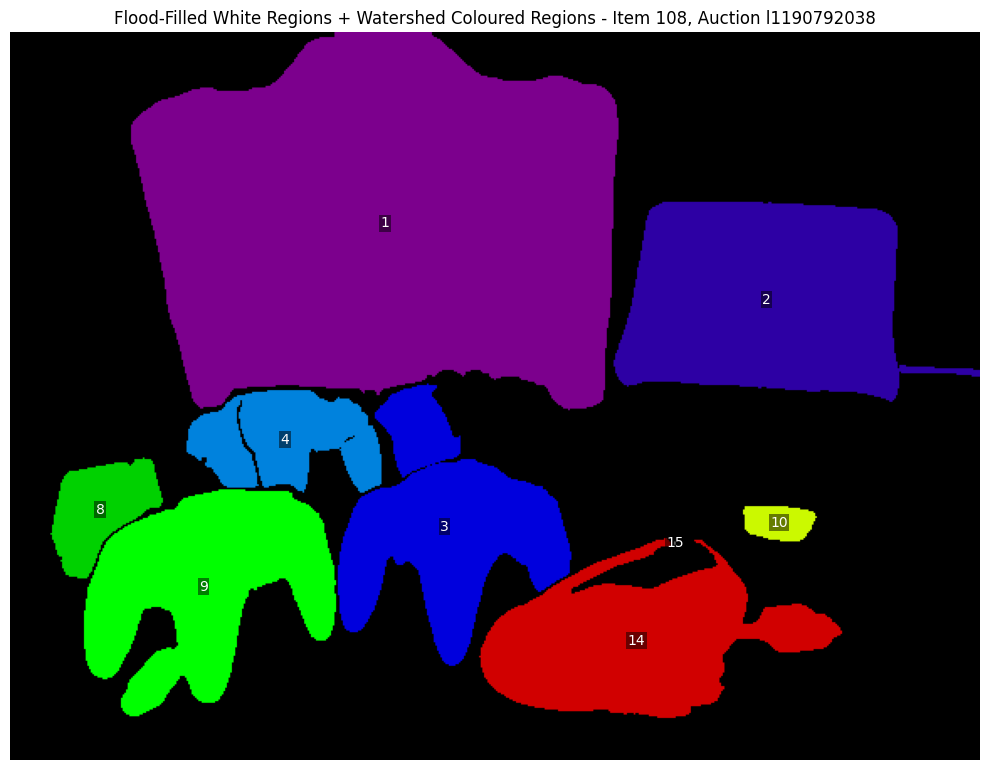

In [65]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from skimage.segmentation import watershed

# ────────────── Setup ──────────────
raw_image_path = os.path.join(RAW, str(ITEM), f"{AUCTION}.png")
conf_paths = {
    "conf_1": os.path.join(CONF_1, str(ITEM), f"{AUCTION}.npy"),
    "conf_2": os.path.join(CONF_2, str(ITEM), f"{AUCTION}.npy"),
    "conf_3": os.path.join(CONF_3, str(ITEM), f"{AUCTION}.npy"),
}

# ────────────── Load Image ──────────────
raw_image = cv2.imread(raw_image_path, cv2.IMREAD_UNCHANGED)
if raw_image is None:
    raise FileNotFoundError(f"Could not load image at: {raw_image_path}")
if raw_image.shape[2] != 4:
    raise ValueError("Expected image with alpha channel.")

bgr   = raw_image[:, :, :3]
gray  = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
gray_rgb = np.stack([gray] * 3, axis=-1).astype(np.float32) / 255.0
alpha = raw_image[:, :, 3]
transparent_mask = alpha == 0

# ────────────── Load Individual SAM Masks ──────────────
mask_layers = {"conf_1": [], "conf_2": [], "conf_3": []}
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))  # For erosion

for conf_key, conf_path in conf_paths.items():
    if not os.path.exists(conf_path):
        print(f"Warning: Missing mask file: {conf_path}")
        continue
    masks_array = np.load(conf_path, allow_pickle=True)
    for m in masks_array:
        mask = m['segmentation'] if isinstance(m, dict) else m
        if mask.shape != alpha.shape:
            mask = cv2.resize(mask.astype(np.uint8), (alpha.shape[1], alpha.shape[0]),
                              interpolation=cv2.INTER_NEAREST).astype(bool)
        overlap = np.logical_and(mask, transparent_mask)
        if mask.sum() == 0 or overlap.sum() / mask.sum() > 0.1:
            continue
        # Erode individual masks before combining
        eroded_mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=1).astype(bool)
        mask_layers[conf_key].append(eroded_mask)

# ────────────── Build Composite Color Code ──────────────
c1 = np.logical_or.reduce(mask_layers["conf_1"]) if mask_layers["conf_1"] else np.zeros_like(alpha, dtype=bool)
c2 = np.logical_or.reduce(mask_layers["conf_2"]) if mask_layers["conf_2"] else np.zeros_like(alpha, dtype=bool)
c3 = np.logical_or.reduce(mask_layers["conf_3"]) if mask_layers["conf_3"] else np.zeros_like(alpha, dtype=bool)
combo_code = (c1.astype(np.uint8) << 2) + (c2.astype(np.uint8) << 1) + c3.astype(np.uint8)
white_mask = combo_code == 7
color_mask  = np.isin(combo_code, [3, 5, 6])   # yellow, magenta, teal
allowed_mask = white_mask | color_mask

# ────────────── Flood fill to segment disconnected white regions ──────────────
h, w = white_mask.shape
flood_filled = np.zeros((h+2, w+2), np.uint8)
segmented_mask = np.zeros_like(white_mask, dtype=np.uint16)
label_id = 1

for y in range(h):
    for x in range(w):
        if white_mask[y, x] == 1 and segmented_mask[y, x] == 0:
            mask_copy = white_mask.copy().astype(np.uint8)
            cv2.floodFill(mask_copy, flood_filled, (x, y), 0,
                          loDiff=0, upDiff=0,
                          flags=4 | (label_id << 8))
            filled = (mask_copy == 0) & (white_mask == 1)
            segmented_mask[filled] = label_id
            label_id += 1

# ────────────── Expand each white region into colored regions ──────────────
flood_filled = np.zeros((h + 2, w + 2), np.uint8)

for region_id in range(1, label_id):
    # Create mask of allowed (white+color), but keep other regions blocked
    current_seed_mask = (allowed_mask & (segmented_mask != region_id))
    seed_coords = np.argwhere(segmented_mask == region_id)

    if seed_coords.size == 0:
        continue

    # Take first seed pixel of this white region
    seed_x, seed_y = int(seed_coords[0][1]), int(seed_coords[0][0])

    mask_copy = allowed_mask.astype(np.uint8)
    flood_filled[:] = 0

    cv2.floodFill(mask_copy, flood_filled, (seed_x, seed_y), 0,
                  loDiff=0, upDiff=0,
                  flags=4 | (region_id << 8))

    # Add newly filled pixels to this region
    filled = (mask_copy == 0) & current_seed_mask
    segmented_mask[filled] = region_id

# ────────────── Visualize Segmented Instances ──────────────
mask_count = segmented_mask.max()
plt.figure(figsize=(10, 10))
plt.imshow(segmented_mask, cmap='nipy_spectral', vmin=0, vmax=mask_count)
for region in regionprops(segmented_mask):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='white', fontsize=10,
             ha='center', va='center',
             bbox=dict(facecolor='black', edgecolor='none', pad=1, alpha=0.5))
plt.title(f"Flood-Filled White Regions + Coloured Regions - Item {ITEM}, Auction {AUCTION}")
plt.axis("off")
plt.tight_layout()
plt.show()


## Visualisation (Mask + Contour)

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

# ────────────── Setup ──────────────
raw_image_path = os.path.join(RAW, str(ITEM), f"{AUCTION}.png")
conf_paths = {
    "conf_1": os.path.join(CONF_1, str(ITEM), f"{AUCTION}.npy"),
    "conf_2": os.path.join(CONF_2, str(ITEM), f"{AUCTION}.npy"),
    "conf_3": os.path.join(CONF_3, str(ITEM), f"{AUCTION}.npy"),
}

# ────────────── Load Image ──────────────
raw_image = cv2.imread(raw_image_path, cv2.IMREAD_UNCHANGED)
if raw_image is None:
    raise FileNotFoundError(f"Could not load image at: {raw_image_path}")
if raw_image.shape[2] != 4:
    raise ValueError("Expected image with alpha channel.")

bgr   = raw_image[:, :, :3]
gray  = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
gray_rgb = np.stack([gray] * 3, axis=-1).astype(np.float32) / 255.0
alpha = raw_image[:, :, 3]
transparent_mask = alpha == 0

# ────────────── Load Individual SAM Masks ──────────────
mask_layers = {"conf_1": [], "conf_2": [], "conf_3": []}

for conf_key, conf_path in conf_paths.items():
    if not os.path.exists(conf_path):
        print(f"Warning: Missing mask file: {conf_path}")
        continue

    masks_array = np.load(conf_path, allow_pickle=True)

    for m in masks_array:
        mask = m['segmentation'] if isinstance(m, dict) else m

        if mask.shape != alpha.shape:
            mask = cv2.resize(mask.astype(np.uint8),
                              (alpha.shape[1], alpha.shape[0]),
                              interpolation=cv2.INTER_NEAREST).astype(bool)

        overlap = np.logical_and(mask, transparent_mask)
        if mask.sum() == 0 or overlap.sum() / mask.sum() > 0.9:
            continue

        mask_layers[conf_key].append(mask)

# ────────────── Visualize RGB Composite with White-Only Labels ──────────────
height, width = alpha.shape
layered_rgb = np.zeros((height, width, 3), dtype=np.float32)

color_map_per_layer = {
    "conf_1": (1.0, 0.0, 0.0),  # Red
    "conf_2": (0.0, 1.0, 0.0),  # Green
    "conf_3": (0.0, 0.0, 1.0),  # Blue
}

# Recompute flattened masks for combo code assignment
c1 = np.logical_or.reduce(mask_layers["conf_1"]) if mask_layers["conf_1"] else np.zeros_like(alpha, dtype=bool)
c2 = np.logical_or.reduce(mask_layers["conf_2"]) if mask_layers["conf_2"] else np.zeros_like(alpha, dtype=bool)
c3 = np.logical_or.reduce(mask_layers["conf_3"]) if mask_layers["conf_3"] else np.zeros_like(alpha, dtype=bool)
combo_code = (c1.astype(np.uint8) << 2) + (c2.astype(np.uint8) << 1) + c3.astype(np.uint8)

instance_id = 1
all_labels = []

# Composite each mask and label only if combo code == 7
for conf_key, masks in mask_layers.items():
    color = np.array(color_map_per_layer[conf_key])
    for mask in masks:
        m_3c = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        layered_rgb = np.where(m_3c, layered_rgb + color, layered_rgb)

        # Only label if this mask is part of a white region (combo_code == 7)
        if not np.any(np.logical_and(mask, combo_code == 7)):
            continue

        labeled = label(mask)
        props = regionprops(labeled)
        if props:
            cy, cx = props[0].centroid
            all_labels.append((cx, cy, instance_id))
            instance_id += 1

# Clip to [0, 1]
layered_rgb = np.clip(layered_rgb, 0.0, 1.0)

# ────────────── Plot ──────────────
plt.figure(figsize=(10, 10))
plt.imshow(layered_rgb)
plt.title(f"Layered SAM Masks (Labelled Only for White Regions) - Item {ITEM}, Auction {AUCTION}")
for (x, y, label_id) in all_labels:
    plt.text(x, y, str(label_id), color='white', fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='black', edgecolor='none', pad=1, alpha=0.6))

plt.axis("off")
plt.tight_layout()
plt.show()



In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries

# ────────────── Setup ──────────────
raw_image_path = os.path.join(RAW, str(ITEM), f"{AUCTION}.png")
conf_paths = {
    "conf_1": os.path.join(CONF_1, str(ITEM), f"{AUCTION}.npy"),
    "conf_2": os.path.join(CONF_2, str(ITEM), f"{AUCTION}.npy"),
    "conf_3": os.path.join(CONF_3, str(ITEM), f"{AUCTION}.npy"),
}

# ────────────── Load Image ──────────────
raw_image = cv2.imread(raw_image_path, cv2.IMREAD_UNCHANGED)
if raw_image is None:
    raise FileNotFoundError(f"Could not load image at: {raw_image_path}")
if raw_image.shape[2] != 4:
    raise ValueError("Expected image with alpha channel.")

bgr   = raw_image[:, :, :3]
gray  = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
gray_rgb = np.stack([gray] * 3, axis=-1).astype(np.float32) / 255.0
alpha = raw_image[:, :, 3]
transparent_mask = alpha == 0

# ────────────── Load Individual SAM Masks ──────────────
mask_layers = {"conf_1": [], "conf_2": [], "conf_3": []}

for conf_key, conf_path in conf_paths.items():
    if not os.path.exists(conf_path):
        print(f"Warning: Missing mask file: {conf_path}")
        continue

    masks_array = np.load(conf_path, allow_pickle=True)

    for m in masks_array:
        mask = m['segmentation'] if isinstance(m, dict) else m

        if mask.shape != alpha.shape:
            mask = cv2.resize(mask.astype(np.uint8),
                              (alpha.shape[1], alpha.shape[0]),
                              interpolation=cv2.INTER_NEAREST).astype(bool)

        overlap = np.logical_and(mask, transparent_mask)
        if mask.sum() == 0 or overlap.sum() / mask.sum() > 0.9:
            continue

        mask_layers[conf_key].append(mask)

# ────────────── Visualize RGB Composite with White-Only Labels ──────────────
height, width = alpha.shape
layered_rgb = np.zeros((height, width, 3), dtype=np.float32)

color_map_per_layer = {
    "conf_1": (1.0, 0.0, 0.0),  # Red
    "conf_2": (0.0, 1.0, 0.0),  # Green
    "conf_3": (0.0, 0.0, 1.0),  # Blue
}



# Recompute combo_code map
c1 = np.logical_or.reduce(mask_layers["conf_1"]) if mask_layers["conf_1"] else np.zeros_like(alpha, dtype=bool)
c2 = np.logical_or.reduce(mask_layers["conf_2"]) if mask_layers["conf_2"] else np.zeros_like(alpha, dtype=bool)
c3 = np.logical_or.reduce(mask_layers["conf_3"]) if mask_layers["conf_3"] else np.zeros_like(alpha, dtype=bool)
combo_code = (c1.astype(np.uint8) << 2) + (c2.astype(np.uint8) << 1) + c3.astype(np.uint8)

# Track outlines and centroids of white masks
outline_mask = np.zeros_like(alpha, dtype=bool)
instance_id = 1
label_locations = []

for conf_key, masks in mask_layers.items():
    for mask in masks:
        # Only process white-region masks (combo_code == 7)
        mask_is_white = np.logical_and(mask, combo_code == 7)
        if not np.any(mask_is_white):
            continue

        # Find outline of the white part
        boundary = find_boundaries(mask_is_white, mode='outer')
        outline_mask |= boundary

        # Label
        props = regionprops(label(mask_is_white))
        if props:
            cy, cx = props[0].centroid
            label_locations.append((cx, cy, instance_id))
            instance_id += 1

# Overlay white boundaries in cyan on the RGB composite
plt.figure(figsize=(10, 10))
plt.contour(outline_mask, colors='cyan', linewidths=0.5, origin ='lower')
plt.imshow(layered_rgb)
plt.title(f"White Region Outlines + Labels - Item {ITEM}, Auction {AUCTION}")
for (x, y, label_id) in label_locations:
    plt.text(x, y, str(label_id), color='white', fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='black', edgecolor='none', pad=1, alpha=0.6))

plt.axis("off")
plt.tight_layout()
plt.show()


